# Import packages

In [2]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import pandas as pd
import matplotlib.colors
from scipy.stats import spearmanr, pearsonr

def make_aesthetic(hex_color_list=None, with_gridlines=False, bold_title=False, save_transparent=True, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta
        "#00A896", # Persian green,
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)
    return hex_color_list
    
mypal = make_aesthetic()


# Data wrangling

In [3]:
df = pd.read_csv("exoneration_mar22_2024.csv")

In [4]:
df.head()

,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,...,Posting Date,OM Tags,F/MFE,FC,ILD,P/FA,DNA,MWID,OM,Date of Crime Year
0,Abbitt,Joseph,31.0,Black,Male,North Carolina,Forsyth,CV;#IO;#SA,Child Sex Abuse,Life,...,9/1/2011,NaN,NaN,NaN,NaN,NaN,DNA,MWID,NaN,"1,991"
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,...,2/14/2022,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,"2,008"
2,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO;#SA,Sexual Assault,20 to Life,...,8/29/2011,OF;#WH;#NW;#WT,F/MFE,NaN,NaN,NaN,DNA,MWID,OM,"1,982"
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,...,2/13/2015,OF;#WH;#NW;#INT,NaN,FC,NaN,P/FA,DNA,NaN,OM,"1,984"
4,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,20 to Life,...,5/13/2019,NaN,NaN,NaN,NaN,NaN,NaN,MWID,NaN,"2,005"


In [5]:
print(len(df))

3486


In [5]:

def winsorize_data(data, lower_percent=0.05, upper_percent=0.05):
    # Calculate the percentile values
    lower_bound = data.quantile(lower_percent)
    upper_bound = data.quantile(1 - upper_percent)

    # Replace values outside the percentile range
    winsorized_data = data.clip(lower=lower_bound, upper=upper_bound)

    return winsorized_data



def get_decade(year):
    return (year // 10) * 10
    
def clean_yr(x):
    x = x.replace(",", "")
    return int(x) 
    
def extract_sentence(sentence):
    if pd.isna(sentence) or not any(char.isdigit() for char in sentence):
        return np.nan

    # Extract numbers from the string
    numbers = [int(s) for s in sentence.split() if s.isdigit()]

    if 'to Life' in sentence and numbers:
        return numbers[0]
    elif 'to' in sentence and len(numbers) >= 2:
        return sum(numbers[:2]) / 2
    elif 'and' in sentence and len(numbers) >= 2:
        return numbers[0] + numbers[1] / 12
    elif 'year' in sentence or 'years' in sentence and len(numbers) >= 1:
        return numbers[0]
    elif 'day' in sentence or 'days' in sentence and len(numbers) >= 1:
        # Assuming the format is 'N days'
        return numbers[0] / 365
    else:
        return np.nan


df = pd.read_csv("exoneration_mar22_2024.csv")
# parse sentence and winsorize at 95% prcentile
df['yrs_sent'] = df['Sentence'].apply(extract_sentence)
df['yrs_sentw'] = winsorize_data(df['yrs_sent'], lower_percent=0, upper_percent=0.05)
df['log_yrs_sent'] = np.log(df['yrs_sent']+1)

# Calc correction_time in sentence date and exoneration date
df['sentence_date'] = df['Date of Crime Year'].apply(clean_yr)
df['exoneration_date'] = df['Exonerated'].astype(int)
df['correction_time'] = df['exoneration_date'] - df['sentence_date'] 

# Misc other features 
df['sentence_decade'] = df['sentence_date'].apply(get_decade)
df['exoneration_decade'] = df['exoneration_date'].apply(get_decade)
df['worst_crime'] = df['Worst Crime Display']

# Drop if cant find sentence date or severity
df = df.dropna(subset=['yrs_sent', 'sentence_date'])

print(len(df))


1973


In [6]:
df.head()

,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,...,Date of Crime Year,yrs_sent,yrs_sentw,log_yrs_sent,sentence_date,exoneration_date,correction_time,sentence_decade,exoneration_decade,worst_crime
2,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO;#SA,Sexual Assault,20 to Life,...,"1,982",20.000000,20.000000,3.044522,1982,1999,17,1980,1990,Sexual Assault
4,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,20 to Life,...,"2,005",20.000000,20.000000,3.044522,2005,2012,7,2000,2010,Robbery
5,Abrego,Eruby,20.0,Hispanic,Male,Illinois,Cook,CDC;#H;#IO,Murder,90 years,...,"1,999",90.000000,67.000000,4.510860,1999,2022,23,1990,2020,Murder
6,Acero,Longino,35.0,Hispanic,Male,California,Santa Clara,NC;#P,Sex Offender Registration,2 years and 4 months,...,"1,994",2.333333,2.333333,1.203973,1994,2006,12,1990,2000,Sex Offender Registration
7,Adams,Anthony,26.0,Hispanic,Male,California,Los Angeles,H;#P,Manslaughter,12 years,...,"1,996",12.000000,12.000000,2.564949,1996,2001,5,1990,2000,Manslaughter


In [7]:
df.to_csv("clean_exoneration.csv")

# Descriptives

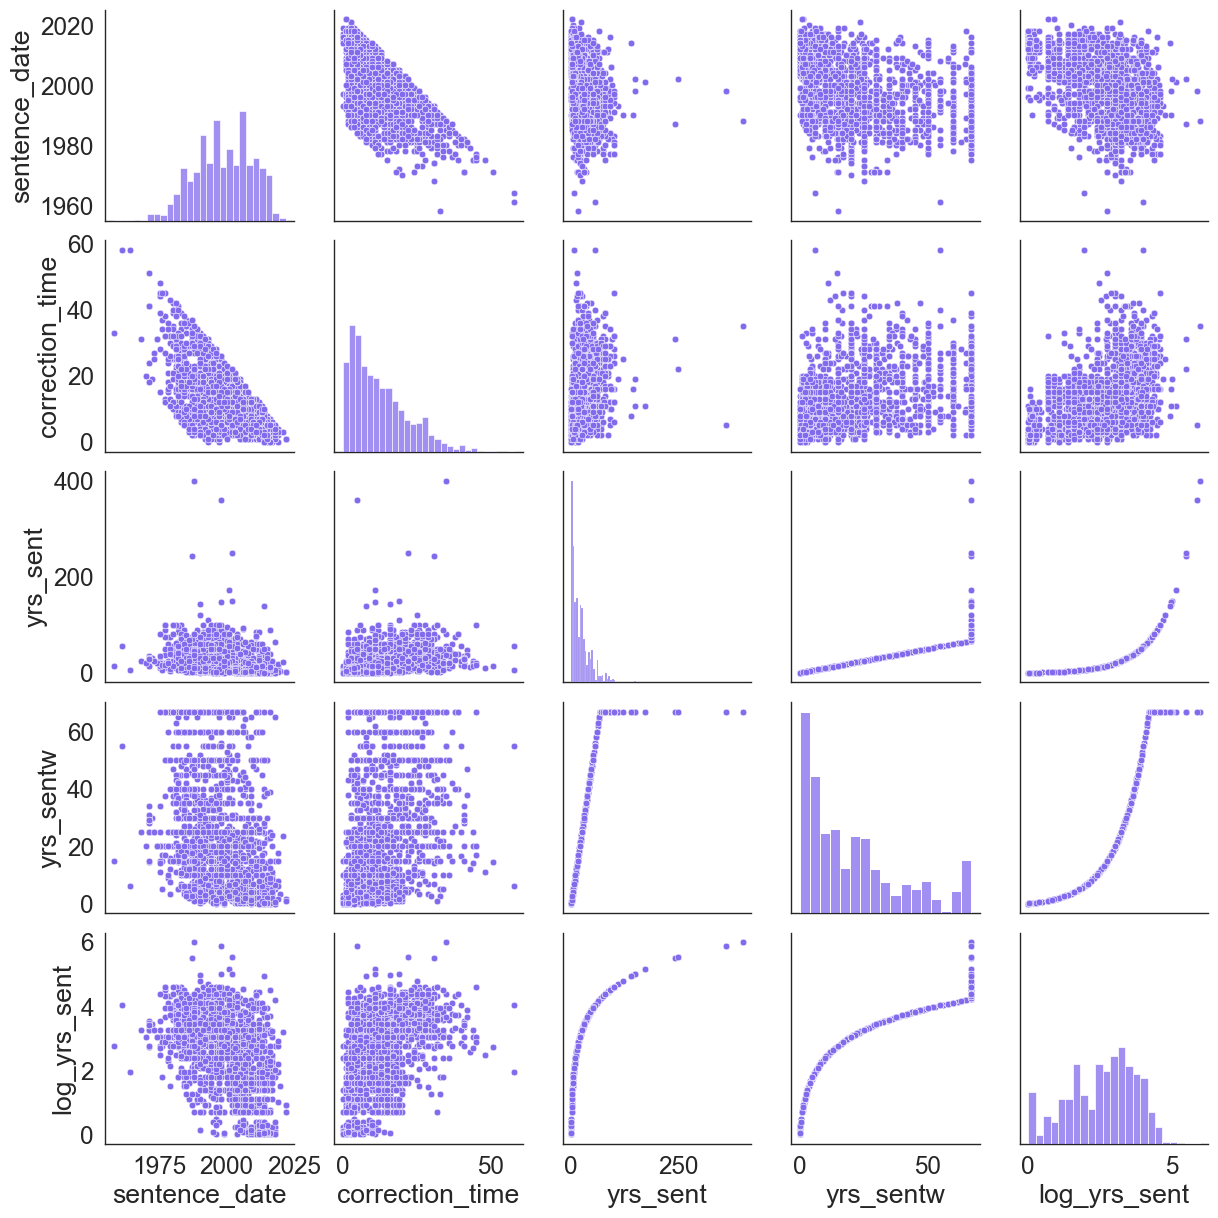

In [8]:
vars = ['sentence_date', 'correction_time', 'yrs_sent', 'yrs_sentw', 'log_yrs_sent']
sns.pairplot(df[vars])

Text(0, 0.5, 'Correction Time\n(Years)')

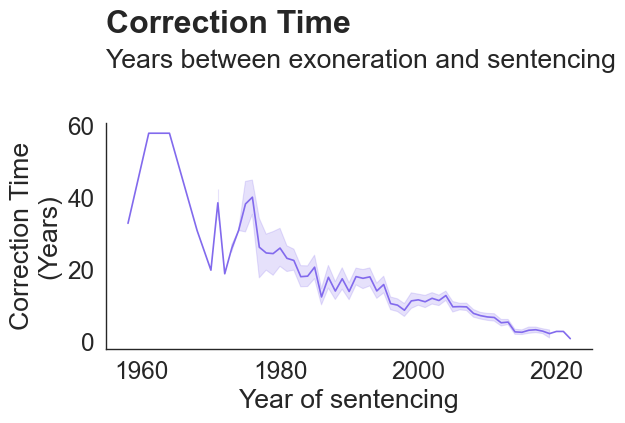

In [9]:
sns.lineplot(data=df, x='sentence_date', y='correction_time')
plt.suptitle("Correction Time", x=0.387, fontweight='bold', y=0.9)
plt.title("Years between exoneration and sentencing", fontweight='regular')
plt.xlabel("Year of sentencing")
plt.ylabel("Correction Time\n(Years)")

## Plot by decade

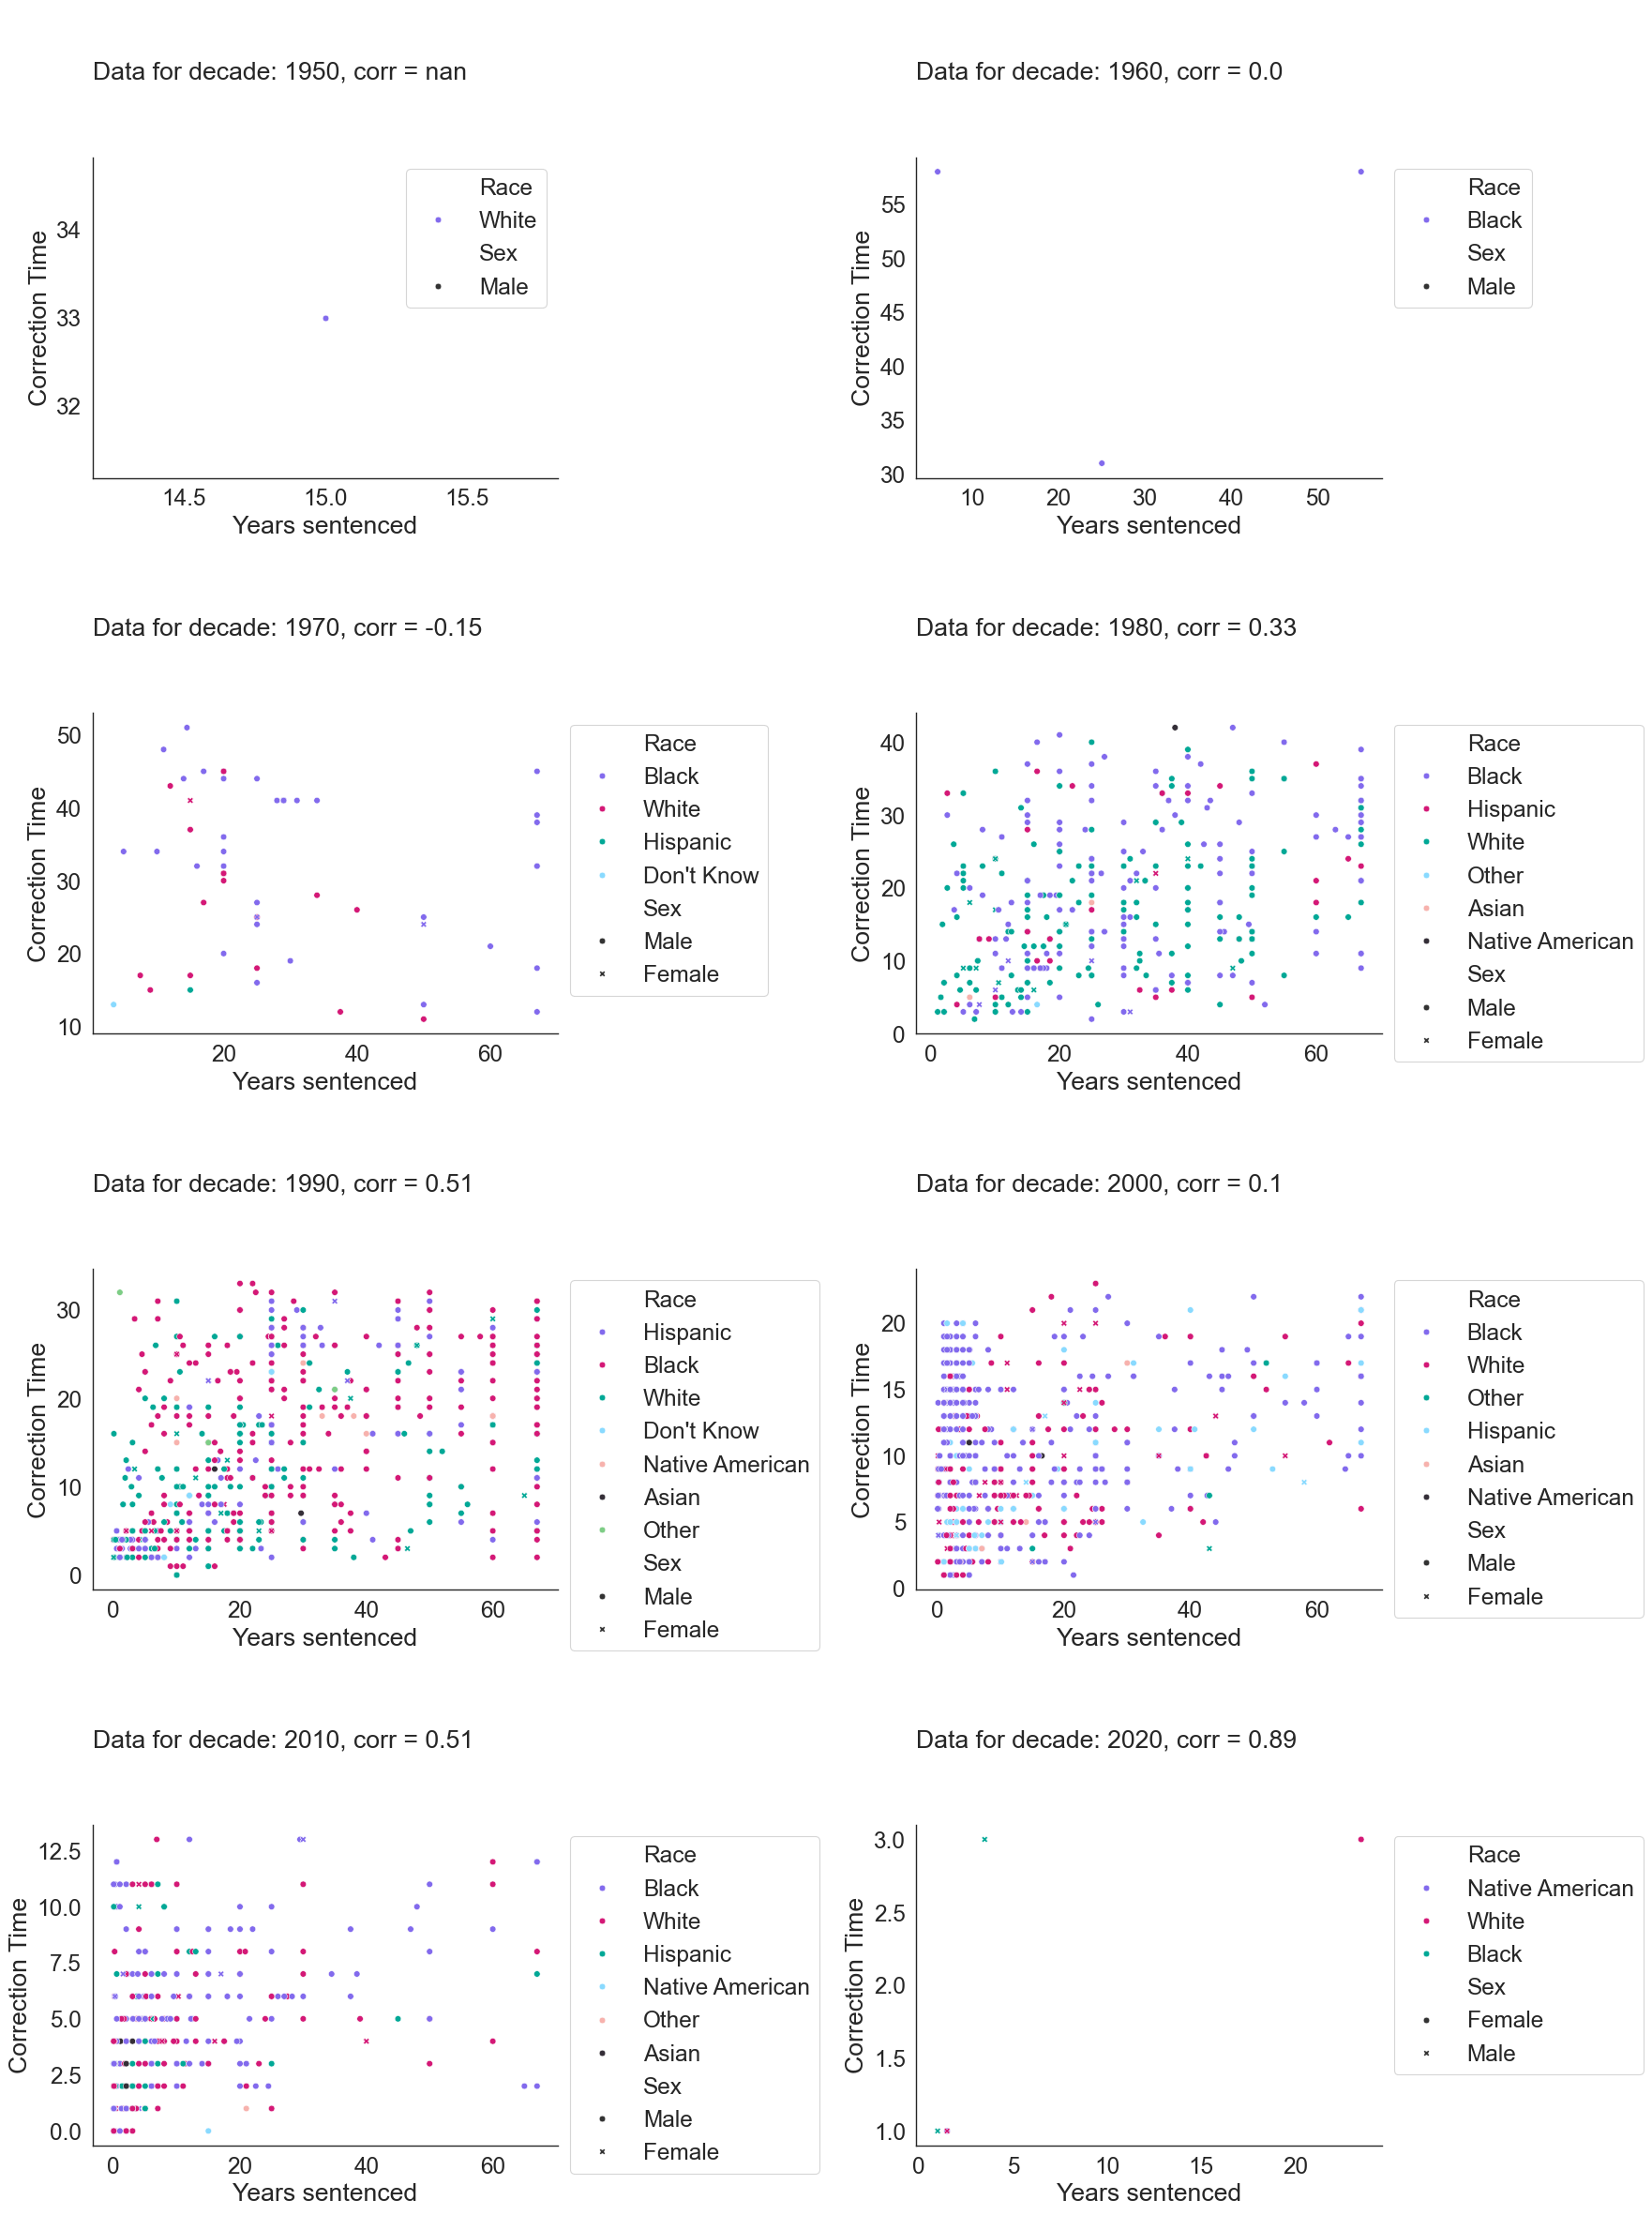

In [10]:
sent_var = 'yrs_sentw'
decades = sorted(df['sentence_decade'].unique())
fig, axs = plt.subplots(nrows=int(np.ceil(len(decades) / 2)), ncols=2, figsize=(18, 6 * int(np.ceil(len(decades) / 2))))
axs = axs.flatten()

for i, decade in enumerate(decades):
    tdf = df[df['sentence_decade'] == decade]
    corr = np.round(tdf[[sent_var, 'correction_time']].corr('spearman').reset_index()['yrs_sentw'].iloc[1], 2)
    
    sns.scatterplot(ax=axs[i], data=tdf, x=sent_var, y='correction_time', hue='Race', style='Sex')
    axs[i].set_title(f"\n\nData for decade: {decade}, corr = {corr}\n")
    axs[i].set_xlabel("Years sentenced")
    axs[i].set_ylabel("Correction Time")
    axs[i].legend(bbox_to_anchor=[1, 1])

plt.tight_layout()
plt.show()

## Overall

Text(0.0, 1.0, "Years Sentenced vs Correction Time\n(Spearman's rho = 0.49)")

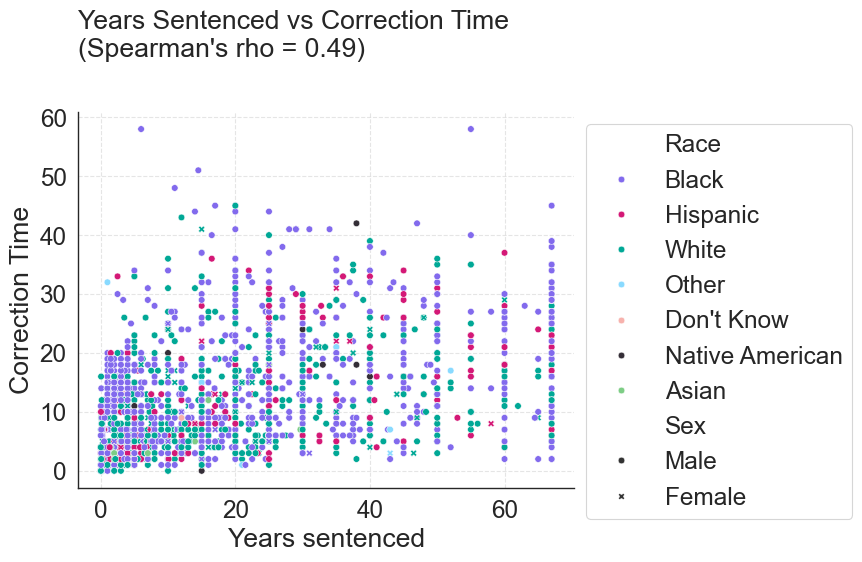

In [40]:
plt.figure(figsize=(9,6))
corr, _ = spearmanr(df['yrs_sentw'], df['correction_time'])

sns.scatterplot(data=df, x='yrs_sentw', y='correction_time', hue='Race', style='Sex')
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Years sentenced")
plt.ylabel("Correction Time")
plt.title(f"Years Sentenced vs Correction Time\n(Spearman's rho = {corr:.2f})")




## BinThresh Method

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_4548/3362322251.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh{yr}", palette=mypal)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_4548/3362322251.py:28: UserWarning: The palette list has more values (15) than needed (4), which may not be intended.
  sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh{yr}", palette=mypal)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_4548/3362322251.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh

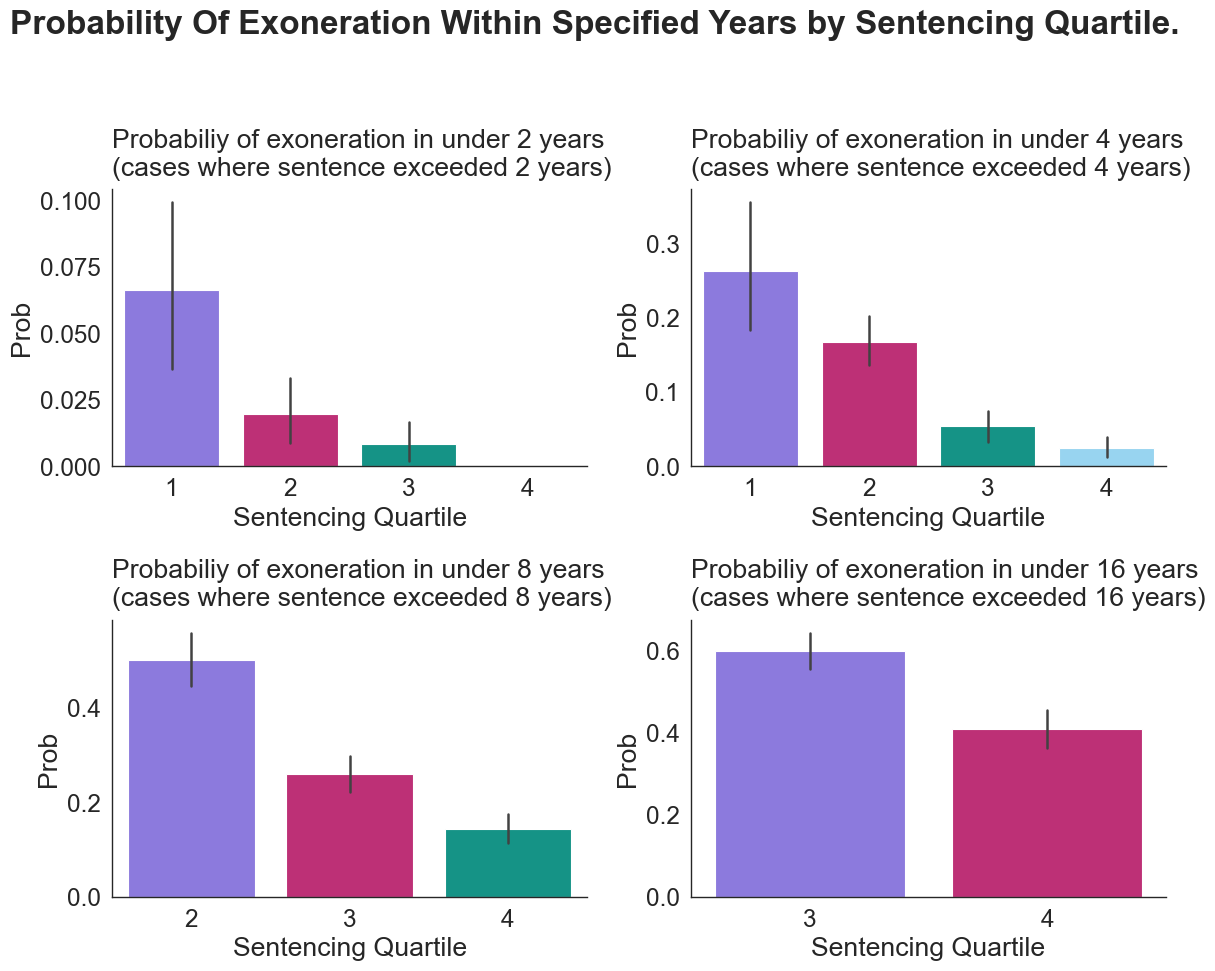

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
def bin_thresh(x, yr_thresh):
    yrs_sent = x['yrs_sent']
    cor_time = x['correction_time']
    if yrs_sent <= yr_thresh:
        return np.NaN 
    else:
        if cor_time < yr_thresh:
            return 1
        else:
            return 0


df['yrs_sentw_bin'] = pd.qcut(df['yrs_sentw'], 4, labels=False) + 1

plt.figure(figsize=(12, 10))

main_title = "Probability Of Exoneration Within Specified Years by Sentencing Quartile."
plt.suptitle(main_title, fontsize=24, fontweight='bold')

for i, yr in enumerate([2, 4, 8, 16], 1):
    df[f"thresh{yr}"] = df.apply(lambda x: bin_thresh(x, yr), axis=1)
    
    plt.subplot(2, 2, i)
    sns.barplot(data=df.dropna(subset=[f"thresh{yr}"]), x='yrs_sentw_bin', y=f"thresh{yr}", palette=mypal)
    plt.xlabel("Sentencing Quartile")
    plt.ylabel("Prob")
    plt.title(f"Probabiliy of exoneration in under {yr} years\n(cases where sentence exceeded {yr} years)", pad=10)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


# OLS

In [41]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='correction_time ~ sentence_date + yrs_sentw + Age + C(Sex) + C(Race) + C(worst_crime) + C(County)', data=df).fit()
display(mod.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        correction_time   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     5.603
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          5.54e-142
Time:                        11:05:15   Log-Likelihood:                -6023.2
No. Observations:                1921   AIC:                         1.300e+04
Df Residuals:                    1443   BIC:                         1.566e+04
Df Model:                         477                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         891.3374     45.161     19.737      0.000     802.750     979.925
C(Sex)[T.Male]                                      1.3149      0.684      1.922      0.055      -0.027       2.657
C(Race)[T.Black]                                    3.4264      1.969      1.741      0.082      -0.435       7.288
C(Race)[T.Don't Know]                               3.8950      3.892      1.001      0.317      -3.740      11.530
C(Race)[T.Hispanic]                                 1.8294      2.012      0.909      0.363      -2.118       5.777
C(Race)[T.Native American]                          3.9217      3.460      1.133      0.257      -2.866      10.709
C(Race)[T.Other]                                   -2.2245      2.902     -0.767      0.443      -7.917       3.468
C(Race)[T.White]                                    1.7840      1.983      0.899      0.369      -2.107       5.675
C(worst_crime)[T.Arson]                            -2.7412      4.846     -0.566      0.572     -12.248       6.765
C(worst_crime)[T.Assault]                          -8.4763      4.363     -1.943      0.052     -17.035       0.082
C(worst_crime)[T.Attempt, Violent]                 -0.1687      4.779     -0.035      0.972      -9.543       9.206
C(worst_crime)[T.Attempted Murder]                 -4.5590      4.357     -1.046      0.296     -13.107       3.989
C(worst_crime)[T.Bribery]                           7.2053      6.341      1.136      0.256      -5.233      19.644
C(worst_crime)[T.Burglary/Unlawful Entry]          -5.1812      4.850     -1.068      0.286     -14.695       4.332
C(worst_crime)[T.Child Abuse]                      -3.6392      4.921     -0.740      0.460     -13.292       6.013
C(worst_crime)[T.Child Sex Abuse]                  -4.5897      4.295     -1.069      0.285     -13.014       3.835
C(worst_crime)[T.Conspiracy]                        3.6181      6.360      0.569      0.569      -8.857      16.093
C(worst_crime)[T.Dependent Adult Abuse]            -4.3854     10.328     -0.425      0.671     -24.646      15.875
C(worst_crime)[T.Drug Possession or Sale]          -4.6585      4.303     -1.083      0.279     -13.099       3.782
C(worst_crime)[T.Failure to Pay Child Support]    -10.9085      8.405     -1.298      0.195     -27.396       5.579
C(worst_crime)[T.Forgery]                          -4.1980      6.212     -0.676      0.499     -16.384       7.988
C(worst_crime)[T.Fraud]                            -3.7619      4.655     -0.808      0.419     -12.893       5.369
C(worst_crime)[T.Immigration]                      -5.2510      5.732     -0.916      0.360     -16.495       5.993
C(worst_crime)[T.Kidnapping]                       -3.6298      4.6

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_4548/27436931.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sum_res = pd.read_html(mod.summary().tables[1].as_html(),header=0,index_col=0)[0].reset_index()
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_4548/27436931.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(y='clean_var', x='coef', data=df_sub, capsize=0.1, join=False, palette=df_sub['color'].tolist())
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_4548/27436931.py:50: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y='clean_var', x='coef', data=df_s

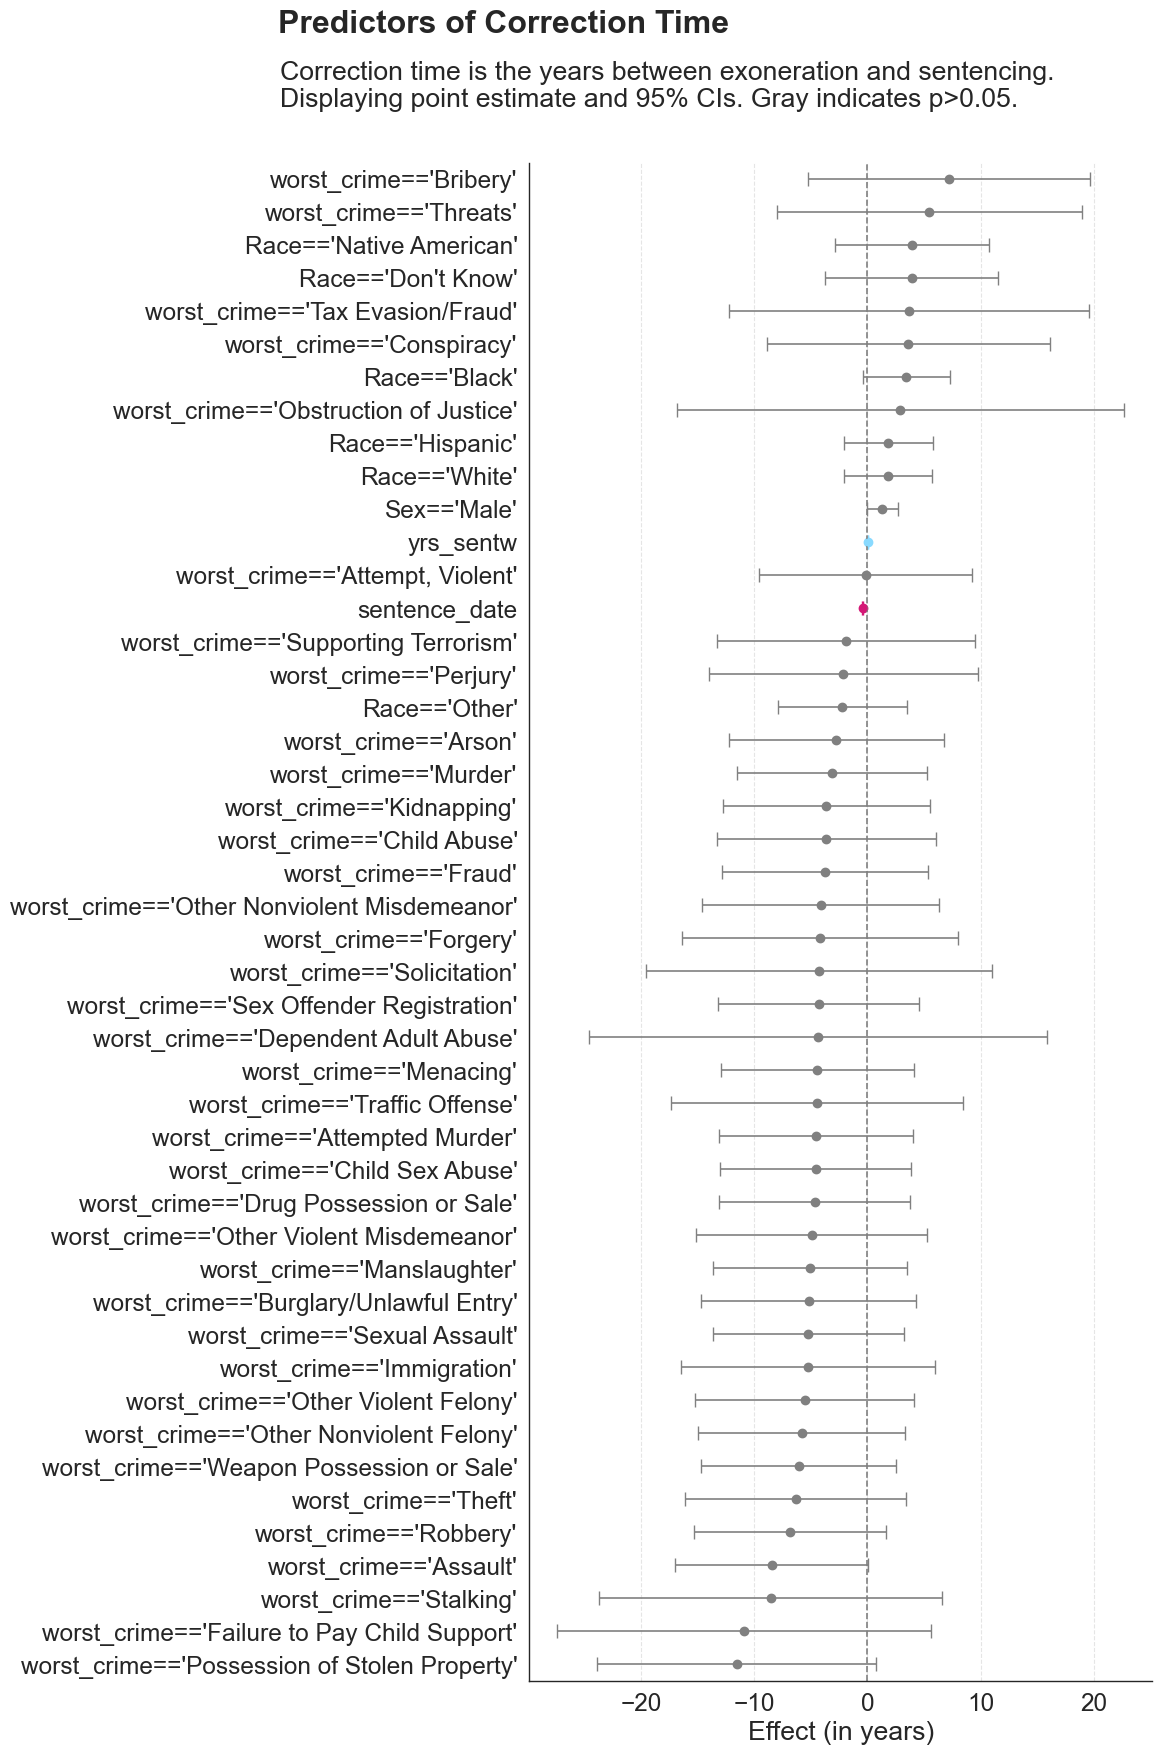

In [42]:
def clean_statsmodels_name(var_name):
    """
    If a name is like C(Race)[T.Other] then it returns Race==Other, 
    else returns normal name. 

    """
    # regex expression to match the pattern 'C(Race)[T.Other]'
    pattern = r'C\((.*?)\)\[T\.(.*?)\]'
    match = re.match(pattern, var_name)

    if match:
        factor, value = match.groups()
        cleaned_name = f"{factor}=='{value}'"
    else:
        # If the pattern does not match, return the original variable name
        cleaned_name = var_name

    return cleaned_name

def filter_vars(all_vars, sub_str):
    matched_vars = set()
    for var in all_vars:
        if any(sub in var for sub in sub_str):
            matched_vars.add(var)

    return list(matched_vars)


sum_res = pd.read_html(mod.summary().tables[1].as_html(),header=0,index_col=0)[0].reset_index()
sum_res = sum_res.rename(columns={'index':'var'})
interesting_vars = ["C(Race)", "C(Sex)", "yrs_sentw", "sentence_date", 'C(worst_crime)']
my_vars = filter_vars(sum_res['var'].tolist(), interesting_vars)

#################
# Plot
#################
make_aesthetic(with_gridlines=True)

df_sub = sum_res.query("var in @my_vars").sort_values(by=['coef'], ascending=False)
df_sub['clean_var'] = df_sub['var'].apply(clean_statsmodels_name)
df_sub['error_lower'] = df_sub['coef'] - df_sub['[0.025']
df_sub['error_upper'] = df_sub['0.975]'] - df_sub['coef']
errors = df_sub[['error_lower', 'error_upper']].T.values
df_sub['color'] = df_sub.apply(lambda row: mypal[3] if (row['P>|t|'] < 0.05 and row['coef'] > 0) else (mypal[1] if (row['P>|t|'] < 0.05 and row['coef'] < 0) else 'gray'), axis=1)

plt.figure(figsize=(12,18))
for index, row in df_sub.iterrows():
    plt.errorbar(row['coef'], row['clean_var'], xerr=[[row['error_lower']], [row['error_upper']]], fmt='o', capsize=5, color=row['color'])
sns.pointplot(y='clean_var', x='coef', data=df_sub, capsize=0.1, join=False, palette=df_sub['color'].tolist())
plt.suptitle("Predictors of Correction Time", fontweight='bold', x=0.435)
plt.title("Correction time is the years between exoneration and sentencing.\nDisplaying point estimate and 95% CIs. Gray indicates p>0.05.", fontweight='regular', x=-0.4)
plt.ylabel("")
plt.xlabel("Effect (in years)")
plt.axvline(x=0, color='gray', linestyle='dashed')


# Life years saved

## Calculcations

In [24]:
def assign_correction_time(df2, x):
    yrs_sent_rank = x['yrs_sent_rank']
    paired_correction_time = df2[df2['time_served_rank'] == yrs_sent_rank]['time_served'].iloc[0]
    return min(x['yrs_sent'], paired_correction_time)

df2 = df.copy()
df2 = df2.sample(frac=1, random_state=42)
df2['time_served'] = np.minimum(df2['correction_time'], df2['yrs_sent'])
df2['yrs_sent_rank'] = df2['yrs_sent'].rank(ascending=False, method='first')
df2['time_served_rank'] = df2['time_served'].rank(ascending=True, method='first')
df2['opt_time_served'] = df2.apply(lambda x: assign_correction_time(df2, x), axis=1)

## Summary stats

In [265]:
opt_time = df2['opt_time_served'].sum()
act_time = df2['time_served'].sum()
reduc_int = opt_time - act_time
reduc_per = (reduc_int/act_time)*100

print(f"Actual time served: {int(np.round(act_time,0))}, Opt time served: {int(np.round(opt_time,0))}, Diff {int(np.round(reduc_int,0))}, Per {int(np.round(reduc_per,0))}")

Actual time served: 19300, Opt time served: 7674, Diff -11626, Per -60


## Plot

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_98946/307030260.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Correction Time Type', y='Total Correction Time', data=df_plot, palette=mypal[2:4])


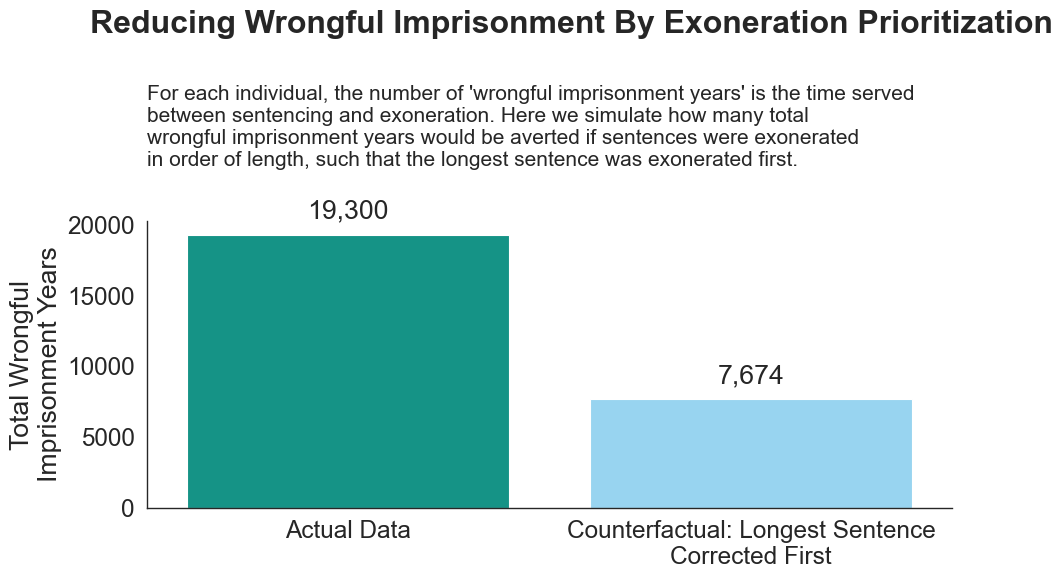

In [64]:
make_aesthetic()
original_time_served_sum = df2['time_served'].sum()
opt_time_served_sum = df2['opt_time_served'].sum()

data_for_plot = {
    'Correction Time Type': ['Actual Data', 'Counterfactual: Longest Sentence\nCorrected First'],
    'Total Correction Time': [original_time_served_sum, opt_time_served_sum]
}

df_plot = pd.DataFrame(data_for_plot)

colors = [matplotlib.colors.to_rgb(mypal[0]), matplotlib.colors.to_rgb(mypal[1])]

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Correction Time Type', y='Total Correction Time', data=df_plot, palette=mypal[2:4])

for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), ',.0f'),  
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom', xytext=(0, 8),
                     textcoords='offset points')

# Set the title and labels
plt.suptitle("Reducing Wrongful Imprisonment By Exoneration Prioritization", fontweight='bold', x=0.59)
plt.title(label="For each individual, the number of 'wrongful imprisonment years' is the time served \nbetween sentencing and exoneration. Here we simulate how many total\nwrongful imprisonment years would be averted if sentences were exonerated\nin order of length, such that the longest sentence was exonerated first.", size=15) 
plt.ylabel('Total Wrongful\nImprisonment Years')
plt.xlabel("")

# Show the plot
plt.show()


In [52]:
np.round(mod.rsquared,2)

0.65